In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tarfile # this is to extract the data from that .tgz file
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

In [2]:
# get all of the data out of that .tgz
amazon_reviews = tarfile.open('/Users/tngumah/Desktop/NLP/Final/amazon_review_polarity_csv.tgz')
amazon_reviews.extractall('/Users/tngumah/Desktop/NLP/Final/data')
amazon_reviews.close()

In [3]:
# check out what the data looks like before you get started
# look at the training data set
train_df = pd.read_csv('./data/amazon_review_polarity_csv/train.csv', header=None)

In [4]:
# look at the test data set
test_df = pd.read_csv('./data/amazon_review_polarity_csv/test.csv', header=None)

In [5]:
train_df.columns = ['rating', 'title', 'review']
train_df = train_df.head(10000)


test_df.columns = ['rating', 'title', 'review']
test_df = test_df.head(10000)


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  10000 non-null  int64 
 1   title   9998 non-null   object
 2   review  10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [7]:
#preprocess and clean data
def preprocess_data(df):
    """
    Preprocesses the training and test DataFrames.

    Parameters:
    - df (pd.DataFrame): The  DataFrame containing 'title', 'review', and 'rating' columns.

    Returns:
    pd.DataFrame: The preprocessed dataframe.
    """
    lemmatizer = WordNetLemmatizer()

    def clean_text(text):
        """
        Lemmatizes the text, converts it to lowercase, and removes punctuation.
        
        Parameters:
        - text (str): The text to clean.

        Returns:
        - str: The cleaned text.
        """
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Tokenize and lemmatize
        tokens = word_tokenize(text)
        lemmatized_text = ' '.join(lemmatizer.lemmatize(token) for token in tokens)
        return lemmatized_text

    # Remove rows with NaN values in combined_text or sentiment
    df = df[df['combined_text'].notna() & df['sentiment'].notna()]

    return df

    #lemmatize and remove stop words
    df['combined_text'] = df['combined_text'].apply(clean_text)

In [8]:
# Map ratings to sentiment labels
def map_sentiment(rating):
    """
    Map rating values to sentiment labels.

    Parameters:
    rating (int): Rating value (1, or 2).

    Returns:
    str: 'negative' for ratings 1 and 2, 'positive' for ratings 4 and 5.
    """
    if rating == 1:
        return 'negative'
    elif rating == 2:
        return 'positive'


In [9]:
# Apply the mapping function to the training and test datasets
train_df['sentiment'] = train_df['rating'].apply(map_sentiment)
test_df['sentiment'] = test_df['rating'].apply(map_sentiment)

In [10]:
# Combine title and review text
train_df['combined_text'] = train_df['title'] + " " + train_df['review']
test_df['combined_text'] = test_df['title'] + " " + test_df['review']


In [11]:
train_df = preprocess_data(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         10000 non-null  int64 
 1   title          10000 non-null  object
 2   review         10000 non-null  object
 3   sentiment      10000 non-null  object
 4   combined_text  10000 non-null  object
dtypes: int64(1), object(4)
memory usage: 390.8+ KB


In [12]:
test_df = preprocess_data(test_df)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9998 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         9998 non-null   int64 
 1   title          9998 non-null   object
 2   review         9998 non-null   object
 3   sentiment      9998 non-null   object
 4   combined_text  9998 non-null   object
dtypes: int64(1), object(4)
memory usage: 468.7+ KB


In [13]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(train_df['combined_text'], train_df['sentiment'], test_size=0.2, random_state=42)

# Test set data
X_test = test_df['combined_text']
y_test = test_df['sentiment']

In [14]:
# Function to train and evaluate models
def train_and_evaluate(vectorizer, model, X_train, X_val, y_train, y_val, X_test, y_test):
    """
    Train a model and evaluate its performance on validation and test sets.

    Parameters:
    vectorizer (Vectorizer): The vectorizer to use for transforming the text data.
    model (Classifier): The model to train.
    X_train (list of str): Training documents.
    X_val (list of str): Validation documents.
    y_train (list of str): Training labels.
    y_val (list of str): Validation labels.
    X_test (list of str): Testing documents.
    y_test (list of str): Testing labels.

    Returns:
    tuple: Validation accuracy, validation report, validation confusion matrix,
           test accuracy, test report, test confusion matrix.
    """
    # Vectorize the training data
    X_train_vec = vectorizer.fit_transform(X_train)
    # Vectorize the validation data
    X_val_vec = vectorizer.transform(X_val)
    
    # Train the model on the training data
    model.fit(X_train_vec, y_train)
    
    # Validate the model on the validation set
    y_val_pred = model.predict(X_val_vec)
    # Calculate validation accuracy
    val_accuracy = accuracy_score(y_val, y_val_pred)
    # Generate validation classification report
    val_report = classification_report(y_val, y_val_pred)
    # Generate validation confusion matrix
    val_cm = confusion_matrix(y_val, y_val_pred)
    
    # Evaluate the model on the test set
    X_test_vec = vectorizer.transform(X_test)  # Vectorize the test data
    y_test_pred = model.predict(X_test_vec)    # Predict on the test set
    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, y_test_pred)
    # Generate test classification report
    test_report = classification_report(y_test, y_test_pred)
    # Generate test confusion matrix
    test_cm = confusion_matrix(y_test, y_test_pred)
    
    return val_accuracy, val_report, val_cm, test_accuracy, test_report, test_cm


In [15]:
# Initialize vectorizers and models
vectorizer_tf = CountVectorizer(max_features=5000)  # Vectorizer for term frequency
vectorizer_tfidf = TfidfVectorizer(max_features=5000)  # Vectorizer for TF-IDF

model_nb = MultinomialNB()  # Naive Bayes classifier
model_lr = LogisticRegression(max_iter=1000)  # Logistic Regression classifier
model_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)  # MLP classifier

# Train and evaluate models with validation and test sets
# Naive Bayes with CountVectorizer (TF)
val_accuracy_nb_tf, val_report_nb_tf, val_cm_nb_tf, test_accuracy_nb_tf, test_report_nb_tf, test_cm_nb_tf = train_and_evaluate(vectorizer_tf, model_nb, X_train, X_val, y_train, y_val, X_test, y_test)

# Naive Bayes with TfidfVectorizer (TF-IDF)
val_accuracy_nb_tfidf, val_report_nb_tfidf, val_cm_nb_tfidf, test_accuracy_nb_tfidf, test_report_nb_tfidf, test_cm_nb_tfidf = train_and_evaluate(vectorizer_tfidf, model_nb, X_train, X_val, y_train, y_val, X_test, y_test)

# Logistic Regression with CountVectorizer (TF)
val_accuracy_lr_tf, val_report_lr_tf, val_cm_lr_tf, test_accuracy_lr_tf, test_report_lr_tf, test_cm_lr_tf = train_and_evaluate(vectorizer_tf, model_lr, X_train, X_val, y_train, y_val, X_test, y_test)

# Logistic Regression with TfidfVectorizer (TF-IDF)
val_accuracy_lr_tfidf, val_report_lr_tfidf, val_cm_lr_tfidf, test_accuracy_lr_tfidf, test_report_lr_tfidf, test_cm_lr_tfidf = train_and_evaluate(vectorizer_tfidf, model_lr, X_train, X_val, y_train, y_val, X_test, y_test)

# MLP with CountVectorizer (TF)
val_accuracy_mlp_tf, val_report_mlp_tf, val_cm_mlp_tf, test_accuracy_mlp_tf, test_report_mlp_tf, test_cm_mlp_tf = train_and_evaluate(vectorizer_tf, model_mlp, X_train, X_val, y_train, y_val, X_test, y_test)

# MLP with TfidfVectorizer (TF-IDF)
val_accuracy_mlp_tfidf, val_report_mlp_tfidf, val_cm_mlp_tfidf, test_accuracy_mlp_tfidf, test_report_mlp_tfidf, test_cm_mlp_tfidf = train_and_evaluate(vectorizer_tfidf, model_mlp, X_train, X_val, y_train, y_val, X_test, y_test)


In [16]:
# Print evaluation results for each model (not included in the original code)
def print_evaluation_results(model_name, val_accuracy, val_report, val_cm, test_accuracy, test_report, test_cm):
    """
    Print the evaluation results for a given model.

    Parameters:
    model_name (str): The name of the model.
    val_accuracy (float): Validation accuracy of the model.
    val_report (str): Validation classification report of the model.
    val_cm (ndarray): Validation confusion matrix of the model.
    test_accuracy (float): Test accuracy of the model.
    test_report (str): Test classification report of the model.
    test_cm (ndarray): Test confusion matrix of the model.
    """
    print(f"Model: {model_name}")
    print(f"Validation Accuracy: {val_accuracy}")
    print("Validation Classification Report:")
    print(val_report)
    print("Validation Confusion Matrix:")
    print(val_cm)
    print(f"Test Accuracy: {test_accuracy}")
    print("Test Classification Report:")
    print(test_report)
    print("Test Confusion Matrix:")
    print(test_cm)
    print("\n")


In [17]:
# Print validation and test results for each model
print_evaluation_results("Naive Bayes with TF", val_accuracy_nb_tf, val_report_nb_tf, val_cm_nb_tf, test_accuracy_nb_tf, test_report_nb_tf, test_cm_nb_tf)
print_evaluation_results("Naive Bayes with TF-IDF", val_accuracy_nb_tfidf, val_report_nb_tfidf, val_cm_nb_tfidf, test_accuracy_nb_tfidf, test_report_nb_tfidf, test_cm_nb_tfidf)
print_evaluation_results("Logistic Regression with TF", val_accuracy_lr_tf, val_report_lr_tf, val_cm_lr_tf, test_accuracy_lr_tf, test_report_lr_tf, test_cm_lr_tf)
print_evaluation_results("Logistic Regression with TF-IDF", val_accuracy_lr_tfidf, val_report_lr_tfidf, val_cm_lr_tfidf, test_accuracy_lr_tfidf, test_report_lr_tfidf, test_cm_lr_tfidf)
print_evaluation_results("MLP with TF", val_accuracy_mlp_tf, val_report_mlp_tf, val_cm_mlp_tf, test_accuracy_mlp_tf, test_report_mlp_tf, test_cm_mlp_tf)
print_evaluation_results("MLP with TF-IDF", val_accuracy_mlp_tfidf, val_report_mlp_tfidf, val_cm_mlp_tfidf, test_accuracy_mlp_tfidf, test_report_mlp_tfidf, test_cm_mlp_tfidf)


Model: Naive Bayes with TF
Validation Accuracy: 0.8385
Validation Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.86      0.85      1037
    positive       0.84      0.82      0.83       963

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

Validation Confusion Matrix:
[[889 148]
 [175 788]]
Test Accuracy: 0.8314662932586517
Test Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.83      0.83      4874
    positive       0.83      0.84      0.84      5124

    accuracy                           0.83      9998
   macro avg       0.83      0.83      0.83      9998
weighted avg       0.83      0.83      0.83      9998

Test Confusion Matrix:
[[4026  848]
 [ 837 4287]]


Model: Naive Bayes with TF-IDF
Validation Accuracy: 0.835
Validation Classification Report:

In [29]:
# Visualize the accuracy of each model
models = ["N_B_TF", "N_B_TF-IDF", "L_R_TF", "L_R_TF-IDF", "MLP_TF", "MLP_TF-IDF"]
val_accuracies = [val_accuracy_nb_tf, val_accuracy_nb_tfidf, val_accuracy_lr_tf, val_accuracy_lr_tfidf, val_accuracy_mlp_tf, val_accuracy_mlp_tfidf]
test_accuracies = [test_accuracy_nb_tf, test_accuracy_nb_tfidf, test_accuracy_lr_tf, test_accuracy_lr_tfidf, test_accuracy_mlp_tf, test_accuracy_mlp_tfidf]

plt.figure(figsize=(14, 6))


<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

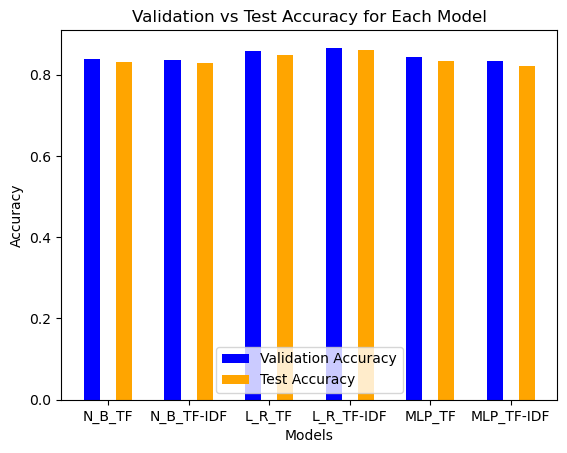

In [30]:
# Create a bar chart to compare validation and test accuracies
x = range(len(models))
plt.bar(x, val_accuracies, width=0.2, label='Validation Accuracy', color='blue', align='center')
plt.bar([p + 0.4 for p in x], test_accuracies, width=0.2, label='Test Accuracy', color='orange', align='center')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Validation vs Test Accuracy for Each Model')
plt.xticks([p + 0.2 for p in x], models)
plt.legend()
plt.show()